# Cox Proportional Hazards Modeling

# Imports

In [1]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter, CoxTimeVaryingFitter
from lifelines.utils import to_episodic_format
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns

# Load Cleaned Data

In [2]:
df_subset = pd.read_csv("Data/cleaned_wideData.csv")
df = pd.read_csv("Data/cleaned_data.csv")

# Cox Proportional Hazards Model - Stratified by sex

In [3]:
# Initialize a cox proportional hazards model
cph = CoxPHFitter()
# Fit the model
cph.fit(df_subset.dropna(), "Time", "Stroke", strata = ["Sex"])
# Display the result summary
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 4275 total observations, 4170 right-censored observations>
             duration col = 'Time'
                event col = 'Stroke'
                   strata = ['Sex']
      baseline estimation = breslow
   number of observations = 4275
number of events observed = 105
   partial log-likelihood = -724.56
         time fit was run = 2021-03-28 23:24:01 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
Age                       0.07       1.07       0.01             0.04             0.10                 1.04                 1.10
Prevalent CHD             0.29       1.34       0.34            -0.37             0.96                 0.69                 2.61
BMI                      -0.01       0.99       0.02            -0.05             0.03                 0.95                 1.03
Anti-Hypertensives        0.47       1.61       0.32            -0.15             1.10                 0.86                 3.00
Systolic blood pressure   0.03       1.03       0.00             0.02             0.03                 1.02                 1.04
Smoke                     0.48       1.62       0.21             0.07             0.89                 1.07                 2.44
Cholesterol              -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Diabetes                  1.10       3.00       0.32             0.46             1.74                 1.59                 5.67

                            z      p   -log2(p)
covariate                                      
Age                      4.96 <0.005      20.40
Prevalent CHD            0.87   0.39       1.37
BMI                     -0.49   0.62       0.69
Anti-Hypertensives       1.49   0.14       2.88
Systolic blood pressure  7.66 <0.005      45.60
Smoke                    2.29   0.02       5.49
Cholesterol             -0.14   0.89       0.17
Diabetes                 3.38 <0.005      10.43
---
Concordance = 0.80
Partial AIC = 1465.13
log-likelihood ratio test = 149.29 on 8 df
-log2(p) of ll-ratio test = 91.55

Our model suggests that there is a statistically significant association between stroke and age, stroke and systolic blood pressure, and stroke and diabetes. Where the hazard of stroke increases by 7% for every year increase in age, adjusting for all other covariates, 95% CI(4%, 10%) $p < 0.005$.
The hazard of stroke increases by 3% for every unit increase in systolic blood pressure, adjusting for all other covariates, 95% CI(2%, 4%) $p < 0.005$.
Finally, the hazard of stroke is greater by a factor of 3 for subjects that are diabetic compared to subjects that are not, keeping all other covariates constant, 95% CI (factor of 1.59, factor of 5.67), $p < 0.005$.

# Time-varying CPH - Stratified by sex

In [4]:
# This is for the full data time
riskFactors = ['AGE',
               'PREVCHD',
               'BMI',
               'BPMEDS',
               'SYSBP',
               'CURSMOKE',
               'TOTCHOL',
               'DIABETES',
               'SEX',
               'TIMESTRK',
               'STROKE',
               'RANDID']
nms = ['Age',
       'Prevalent CHD',
       'BMI',
       'Anti-Hypertensives',
       'Systolic blood pressure',
       'Smoke',
       'Cholesterol',
       'Diabetes',
       'Sex',
       'Time',
       'Stroke',
       'ID']

df_subset_tvc = df[riskFactors].copy()
df_subset_tvc["TIMESTRK"] = df_subset_tvc["TIMESTRK"]+1 # To convert to episodic format can't have time 0
df_subset_tvc.columns = nms
df_subset_tvc = df_subset_tvc.dropna()

# First we need to re-format the data 
df_long = to_episodic_format(df_subset_tvc, duration_col="Time", event_col="Stroke", id_col="ID", time_gaps=1.0)
df_long[["start", "stop"]] = df_long[["start", "stop"]].astype("float64", copy=False)
df_long.Sex = [1 if x == "Female" else 0 for x in df_long.Sex]
df_long.rename(columns={"Sex":"Sex [Female]"}, inplace = True)

# Initialize cox time varying model
ctv = CoxTimeVaryingFitter()
# fit the model
ctv.fit(df_long, 
        id_col='ID', 
        event_col='Stroke', 
        start_col='start', 
        stop_col='stop')
# Summarize results
ctv.print_summary()

<lifelines.CoxTimeVaryingFitter: fitted with 81161381 periods, 4362 subjects, 913 events>
         event col = 'Stroke'
number of subjects = 4362
 number of periods = 81161381
  number of events = 913
partial log-likelihood = -7887.14
  time fit was run = 2021-03-28 23:25:12 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
Age                       0.06       1.06       0.00             0.05             0.06                 1.05                 1.07
Anti-Hypertensives        0.33       1.39       0.09             0.15             0.51                 1.16                 1.67
BMI                       0.02       1.02       0.01             0.00             0.03                 1.00                 1.03
Cholesterol              -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Diabetes                  0.56       1.75       0.11             0.34             0.77                 1.41                 2.16
Prevalent CHD             0.48       1.62       0.10             0.29             0.67                 1.34                 1.96
Sex [Female]             -0.32       0.73       0.07            -0.46            -0.18                 0.63                 0.83
Smoke                     0.46       1.58       0.07             0.32             0.60                 1.37                 1.82
Systolic blood pressure   0.02       1.02       0.00             0.02             0.02                 1.02                 1.02

                            z      p   -log2(p)
covariate                                      
Age                     13.95 <0.005     144.45
Anti-Hypertensives       3.62 <0.005      11.72
BMI                      2.18   0.03       5.09
Cholesterol             -1.18   0.24       2.08
Diabetes                 5.13 <0.005      21.73
Prevalent CHD            4.94 <0.005      20.26
Sex [Female]            -4.53 <0.005      17.35
Smoke                    6.35 <0.005      32.15
Systolic blood pressure 13.21 <0.005     129.87
---
Partial AIC = 15792.27
log-likelihood ratio test = 808.27 on 9 df
-log2(p) of ll-ratio test = 556.26

<p>
The significant covariates for the Cox proportional hazards model that accounts for time-varying covariates, by using the counting process data format, are age, anti-hypertensive medication status, BMI, diabetes status, prevalent coronary heart disease status, smoking status, systolic blood pressure, and sex. The hazard of stroke is 27% less in females compared to males, while adjusting for all other covariates; p $\lt$ 0.005, 95% CI = (0.63, 0.83). There is a 6% increase in the hazard of stroke for every unit increase in age, while adjusting for all other covariates. The hazard of stroke is 39% greater for those who are on anti-hypertensive medication compared to individuals not on anti-hypertensive medication, while adjusting for all other covariates; p $\lt$ 0.005, 95% CI = (1.16, 1.67). There is a 2% increase in the hazard of stroke for every unit increase in BMI; p = 0.03, 95% CI = (1.00, 1.03). The hazard of stroke is 75% greater in diabetics compared to non-diabetics, while adjusting for all other covariates; p $\lt$ 0.005, 95% CI = (1.41, 2.16). The hazard of stroke is 62% greater for individuals with prevalent coronary heart disease status compared to individuals without prevalent coronary heart disease status, while adjusting for all other covariates; p $\lt$ 0.005, 95% CI = (1.34, 1.96). The hazard of stroke is 58% greater in individuals that smoke compared to individuals that do not smoke, while adjusting for all other covariates; p $\lt$ 0.005, 95% CI = (1.37, 1.82). There is a 2% increase in the hazard of stroke for every unit increase in systolic blood pressure, while adjusting for all other covariates; p $\lt$ 0.005, 95% CI = (1.02, 1.02).
</p>

# Visualize Results

### Coefficient plots

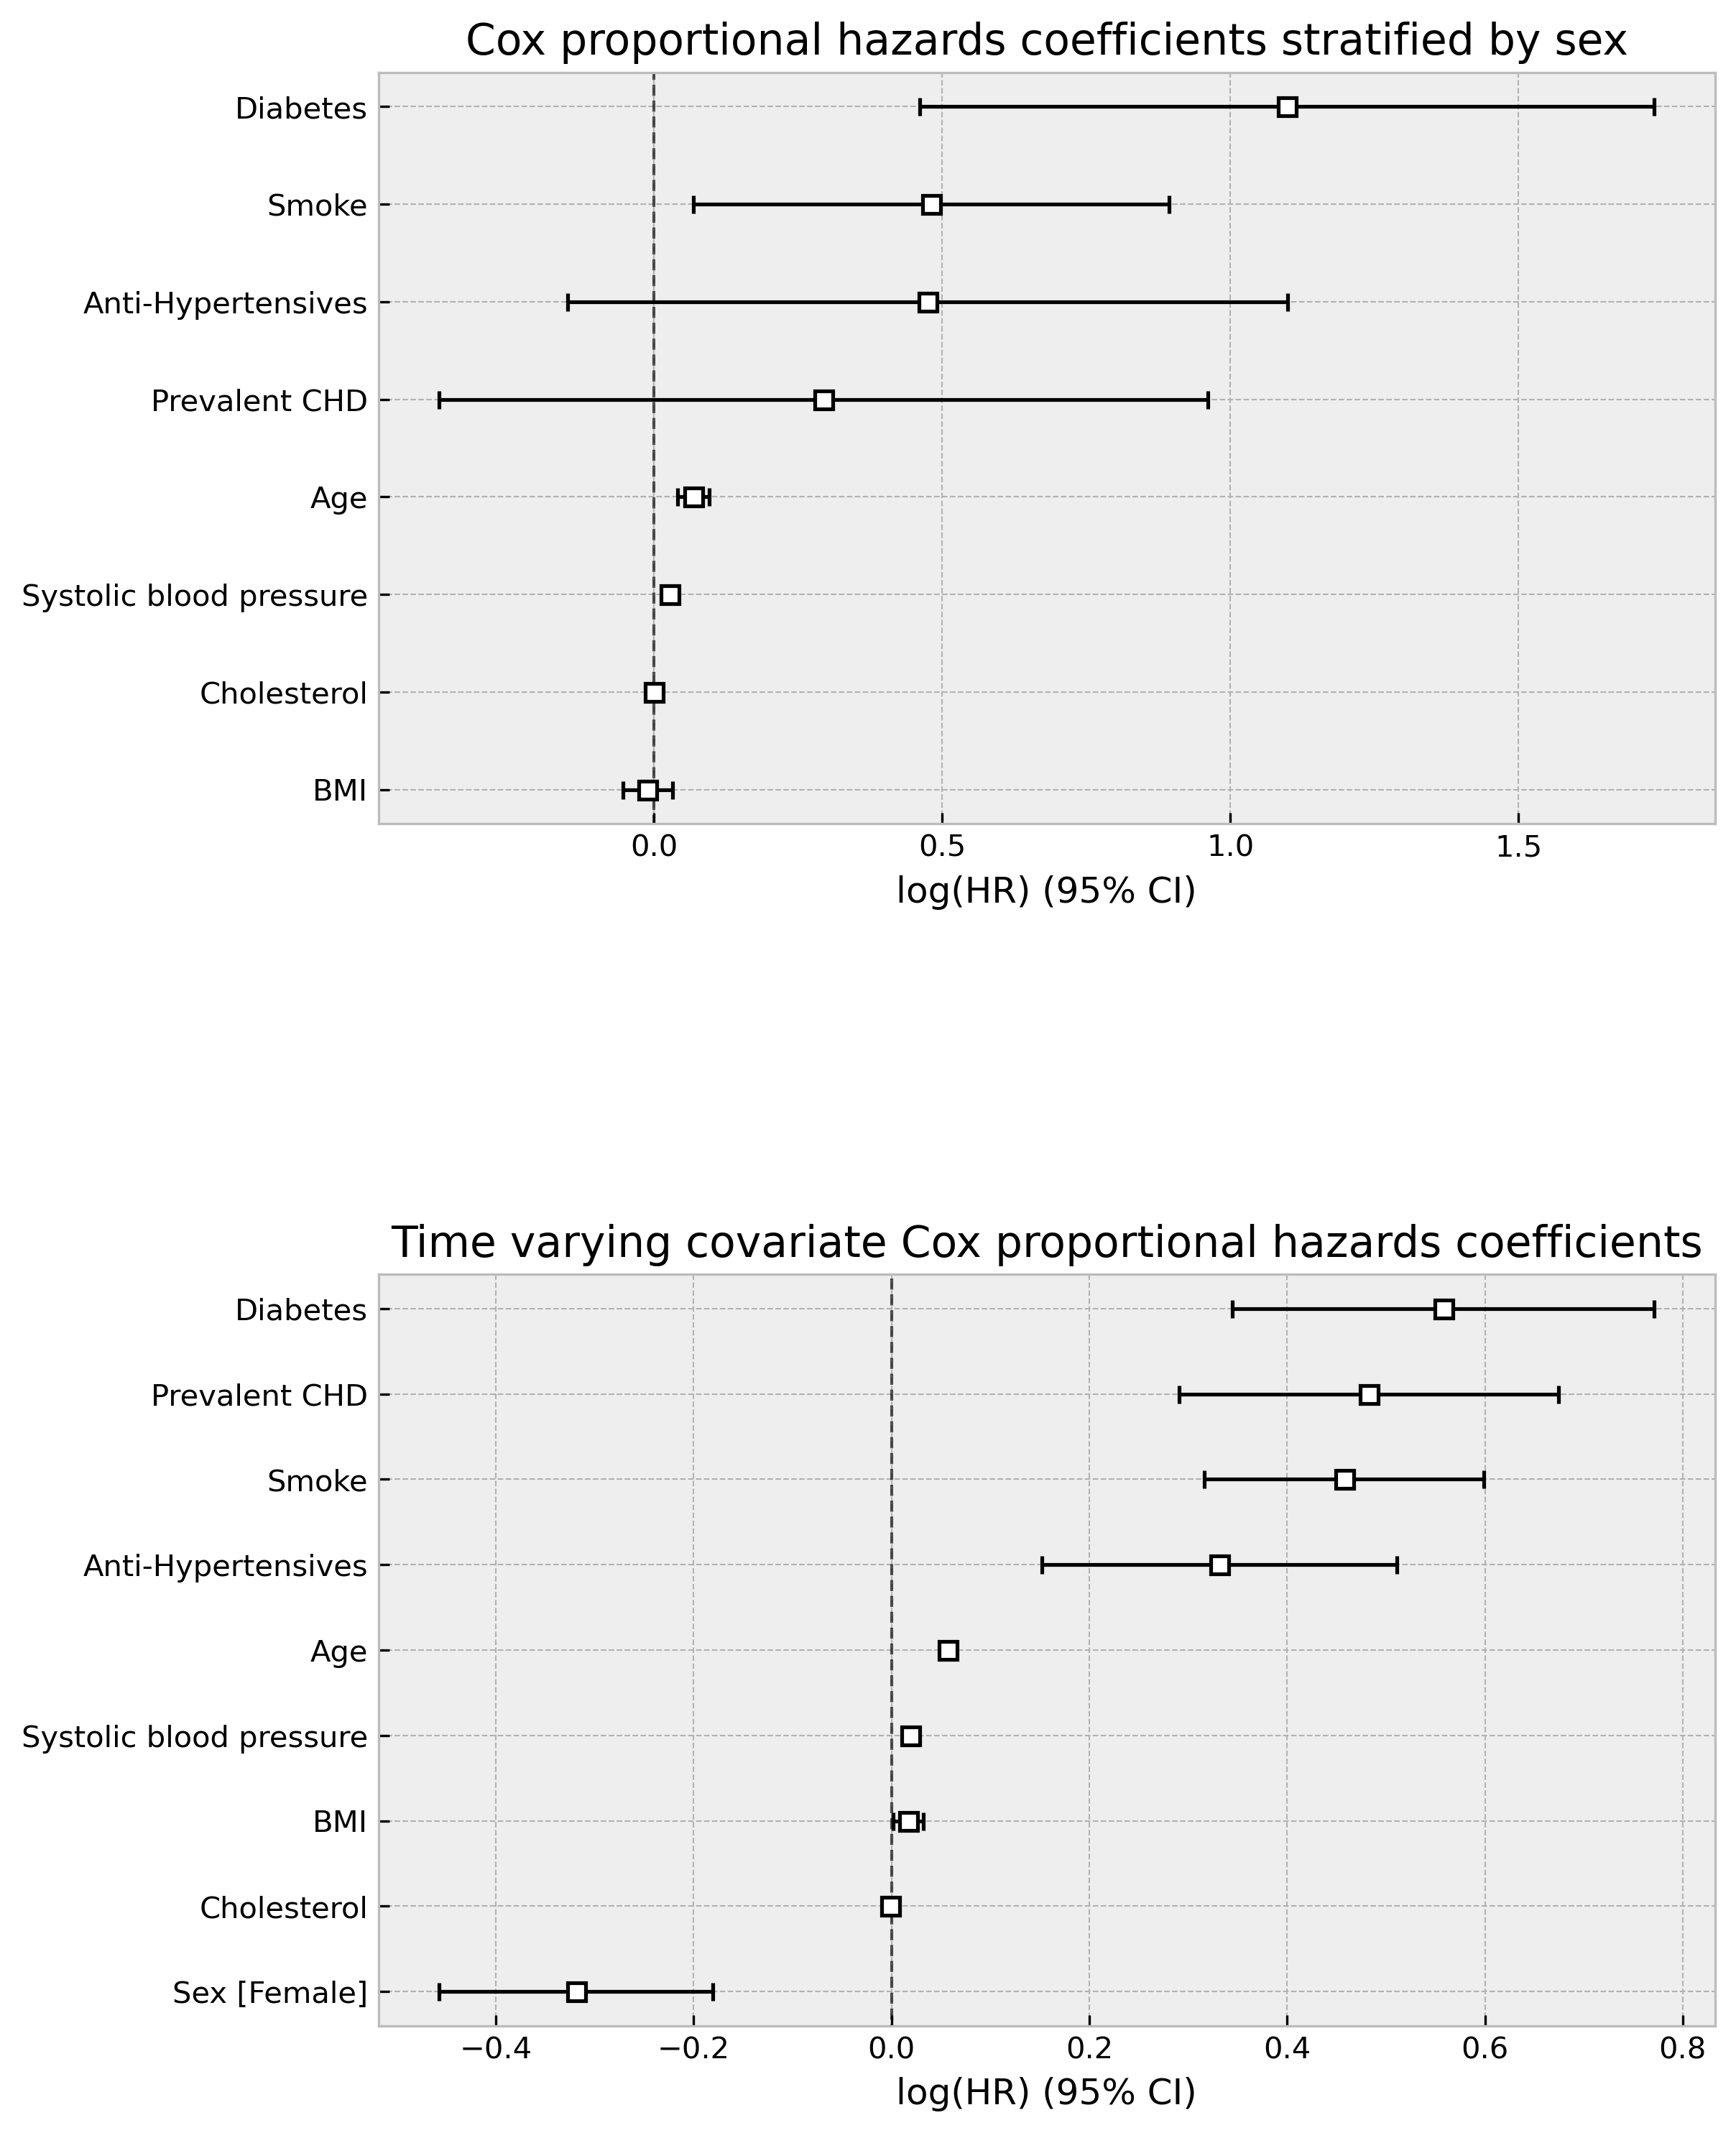

In [59]:
plt.style.use('bmh')
plt.figure(figsize = (8,12), dpi = 300)
fig = gridspec.GridSpec(2, 1, wspace=0.5, hspace =0.6)
x1 = plt.subplot(fig[0, 0])
cph.plot()
plt.title("Cox proportional hazards coefficients stratified by sex")

x3 = plt.subplot(fig[1, 0])
ctv.plot()
plt.title("Time varying covariate Cox proportional hazards coefficients")
plt.show()

In the plot above we can see that significant covariates to the right of the null hypothesis have an increase in the hazard of stroke, whereas the covariates to the left of the null hypothesis have a decrease in the hazard of stroke.

### Risk plots

<Figure size 3600x2400 with 0 Axes>

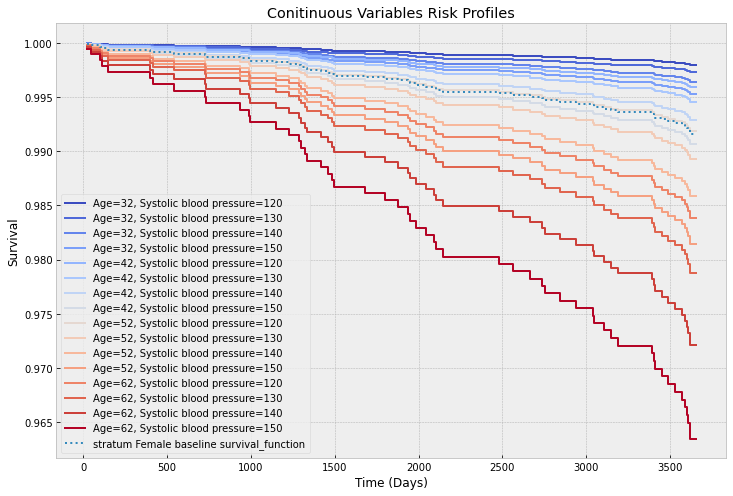

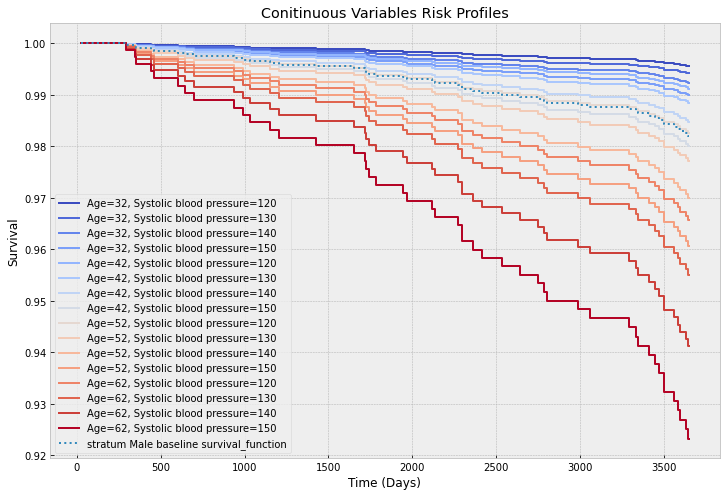

In [42]:
plt.figure(figsize = (12,8), dpi = 300)
cph.plot_partial_effects_on_outcome(covariates=["Age", "Systolic blood pressure"],
                                      values=[[32, 120],
                                              [32, 130],
                                              [32, 140],
                                              [32, 150],
                                              [42, 120],
                                              [42, 130],
                                              [42, 140],
                                              [42, 150],
                                              [52, 120],
                                              [52, 130],
                                              [52, 140],
                                              [52, 150],
                                              [62, 120],
                                              [62, 130],
                                              [62, 140],
                                              [62, 150]
                                             ],
                                    figsize = (12,8),
                                    xlabel = ("Time (Days)"),
                                    ylabel = ("Survival"),
                                    title = ("Conitinuous Variables Risk Profiles"),
                                    cmap ="coolwarm"
                                    )
plt.show()

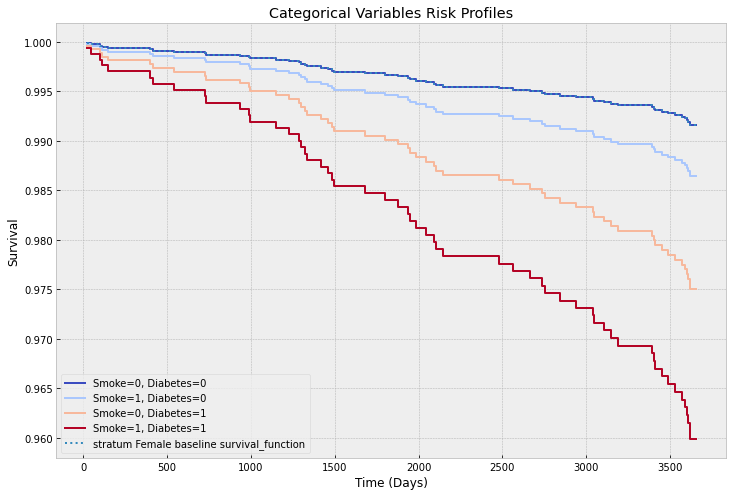

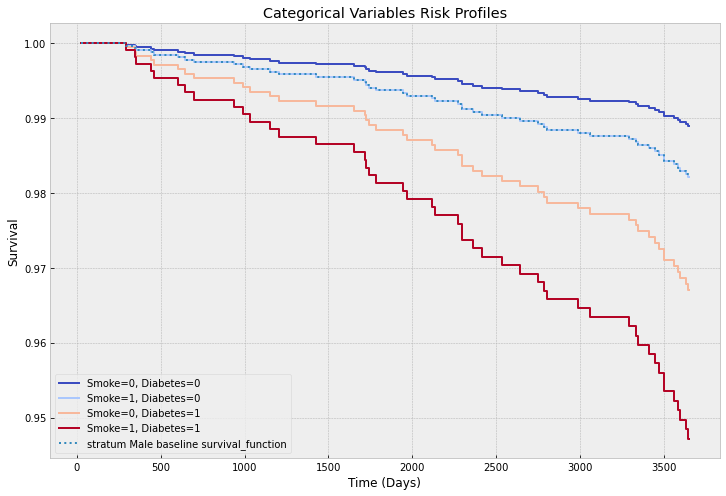

In [43]:
cph.plot_partial_effects_on_outcome(covariates=["Smoke", "Diabetes"],
                                      values=[[0, 0],
                                              [1, 0],
                                              [0, 1],
                                              [1,1]
                                             ],
                                    figsize = (12,8),
                                    xlabel = ("Time (Days)"),
                                    ylabel = ("Survival"),
                                    title = ("Categorical Variables Risk Profiles"),
                                    cmap ="coolwarm"
                                      )

plt.show()

<p>
The figure above depicts the probability of survival (not having a stroke) first for the average baseline hazard function and then for a set of risk profiles, based on what risk factors were significant in our models. For age and systolic blood pressure we explore ages from 32-62 by ten years and systolic blood pressures from 120-150 by ten units, and we generate risk profiles with every combination of those ranges. For the significant categorical variables, we look at risk profiles for every combination of the categories. As we can see in the figures as we increase age and/or we increase systolic blood pressure the risk of stroke at ten years increases; for both males and females. For categorical variables, we can see that having none of the conditions has the least probability of having a stroke, while having both conditions, diabetic and smoker, has the greatest risk for having a stroke. We see that smokers, have a smaller probability of stroke compared to diabetics.
</p>